# model 0
one-hot encoded cell_type and sm_name

In [1]:
import polars as pl
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# import from the auxFunctions.py file
from auxFunctions import calculate_mae_and_mrrmse, mean_rowwise_rmse_loss, custom_mean_rowwise_rmse, create_model_checkpoint, plot_training_history

## pre-process data

In [2]:
de_train = pl.scan_parquet('./kaggledata/de_train.parquet')
de_train_df = de_train.collect().to_pandas()

# test provided by kaggle --> upload predictions to kaggle to get the score
id_map = pd.read_csv('./kaggledata/id_map.csv')

train dataset provided by kaggle
- will be split into train/test/validation for internal testing before model is trained on the entire train and used to predict on the test in id_map

In [3]:
features = de_train_df[['cell_type', 'sm_name']]

# extra features can be derived from the input, specifically 'sm_name'
# might want to use this as further input into later versions of the model to aid prediction
extra_features = de_train_df[['sm_lincs_id', 'SMILES', 'control']]

# wanted output
genes_lfc = de_train_df.drop(columns=['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control'])

In [4]:
encoder = OneHotEncoder()

# fitting & transforming both cell_type & sm_name
encoder.fit(features)
encoded_features = encoder.transform(features)

encoded_kaggle_test = encoder.transform(id_map[['cell_type', 'sm_name']])

In [5]:
# Split the data into 70% training, 15% validation, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(encoded_features, genes_lfc.values, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# used for final training before predicting on kaggle_test
full_features = encoded_features.toarray()
full_labels = genes_lfc.values

## model training

In [6]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

In [7]:
tf.random.set_seed(42)

model_0 = Sequential([
    Dense(512, activation="tanh"),
    Dense(18211, activation="linear")
])

model_0.compile(loss=mean_rowwise_rmse_loss, 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[custom_mean_rowwise_rmse])

history_0 = model_0.fit(X_train, y_train,
                       epochs=10,
                       validation_data=(X_val,y_val),
                       batch_size=32,
                       callbacks=[create_model_checkpoint("model_0", monitor="val_custom_mean_rowwise_rmse")])

Epoch 1/10
14/14 [==============================] - 7s 280ms/step - loss: 1.3655 - custom_mean_rowwise_rmse: 1.3594 - val_loss: 0.8346 - val_custom_mean_rowwise_rmse: 0.8330
Epoch 2/10
14/14 [==============================] - 3s 249ms/step - loss: 1.3458 - custom_mean_rowwise_rmse: 1.3218 - val_loss: 0.8200 - val_custom_mean_rowwise_rmse: 0.8180
Epoch 3/10
14/14 [==============================] - 4s 301ms/step - loss: 1.3279 - custom_mean_rowwise_rmse: 1.3067 - val_loss: 0.8172 - val_custom_mean_rowwise_rmse: 0.8149
Epoch 4/10
14/14 [==============================] - 4s 299ms/step - loss: 1.3144 - custom_mean_rowwise_rmse: 1.2895 - val_loss: 0.8166 - val_custom_mean_rowwise_rmse: 0.8141
Epoch 5/10
14/14 [==============================] - 2s 146ms/step - loss: 1.3025 - custom_mean_rowwise_rmse: 1.3144 - val_loss: 0.8172 - val_custom_mean_rowwise_rmse: 0.8146
Epoch 6/10
14/14 [==============================] - 2s 138ms/step - loss: 1.2906 - custom_mean_rowwise_rmse: 1.2712 - val_loss: 0.

### evaluate model

In [8]:
calculate_mae_and_mrrmse(model=model_0, data=X_test, y_true=y_test)

93/93 [==============================] - 1s 8ms/step
Mean Absolute Error (MAE): 0.8360250613670867
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.2831222657050172


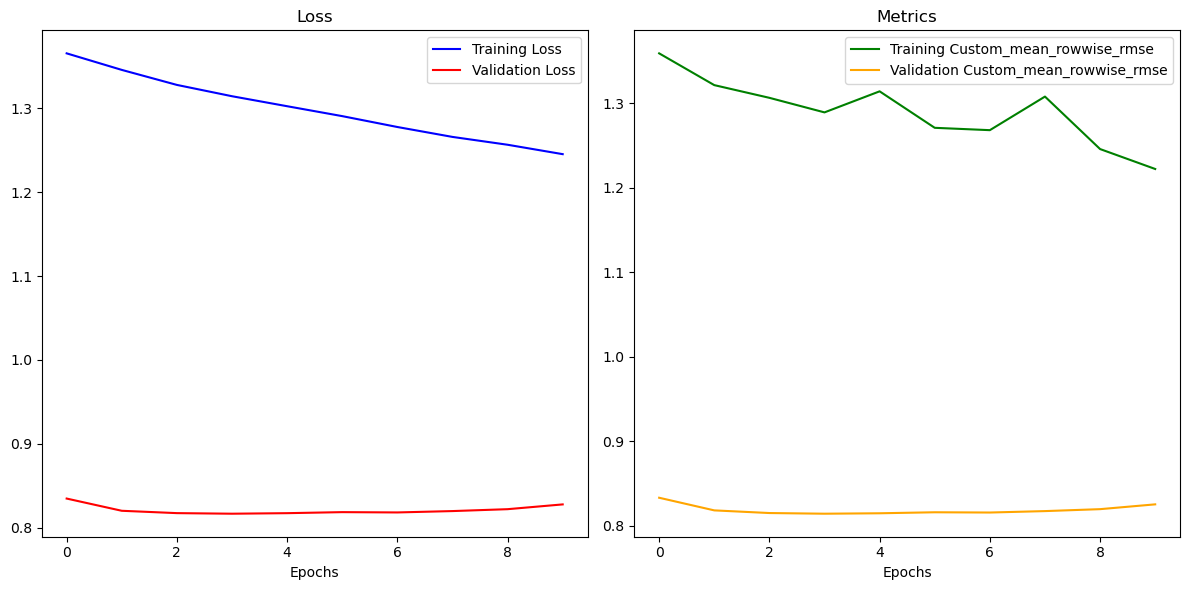

In [9]:
plot_training_history(history_0, metrics=["custom_mean_rowwise_rmse"])

## train on full feature set
predict on encoded_kaggle_test and export to csv

In [17]:
tf.random.set_seed(42)

model_0_full = Sequential([
    Dense(512, activation="tanh"),
    Dense(18211, activation="linear")
])

model_0_full.compile(loss=mean_rowwise_rmse_loss, 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[custom_mean_rowwise_rmse])

history_0_full = model_0_full.fit(full_features, full_labels,
                       epochs=10,
                       batch_size=32,
                       callbacks=[create_model_checkpoint("model_0_full", monitor="val_custom_mean_rowwise_rmse")])

Epoch 1/10
20/20 [==============================] - 5s 134ms/step - loss: 1.2735 - custom_mean_rowwise_rmse: 1.2725
Epoch 2/10
20/20 [==============================] - 3s 130ms/step - loss: 1.2496 - custom_mean_rowwise_rmse: 1.2335
Epoch 3/10
20/20 [==============================] - 3s 126ms/step - loss: 1.2332 - custom_mean_rowwise_rmse: 1.2102
Epoch 4/10
20/20 [==============================] - 3s 129ms/step - loss: 1.2201 - custom_mean_rowwise_rmse: 1.1967
Epoch 5/10
20/20 [==============================] - 3s 132ms/step - loss: 1.2071 - custom_mean_rowwise_rmse: 1.2199
Epoch 6/10
20/20 [==============================] - 3s 126ms/step - loss: 1.1922 - custom_mean_rowwise_rmse: 1.1960
Epoch 7/10
20/20 [==============================] - 3s 136ms/step - loss: 1.1793 - custom_mean_rowwise_rmse: 1.1548
Epoch 8/10
20/20 [==============================] - 3s 144ms/step - loss: 1.1684 - custom_mean_rowwise_rmse: 1.1492
Epoch 9/10
20/20 [==============================] - 3s 144ms/step - loss

In [18]:
kaggle_predictions = model_0_full.predict(encoded_kaggle_test, batch_size=1)

255/255 [==============================] - 2s 7ms/step


In [20]:
sample_submission = pd.read_csv('./kaggledata/sample_submission.csv')
sample_submission.iloc[:,1:] = kaggle_predictions

sample_submission.to_csv('submission_model_0.csv', index=False)

In [21]:
# another method of exporting csv
df = pd.DataFrame(kaggle_predictions, columns=genes_lfc.columns)

df

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.510044,0.292888,0.496628,0.693536,1.421421,1.455420,0.005662,0.524866,0.063046,0.145662,...,-0.240434,0.079328,0.208658,0.558417,0.667351,0.472926,0.366752,0.266349,-0.423768,0.139120
1,0.261349,0.176048,0.133364,0.202835,0.910574,0.854972,0.044288,0.209955,0.163423,-0.043849,...,0.031279,0.077922,-0.021950,0.337379,0.327210,0.216508,0.157860,0.033364,-0.263769,-0.093176
2,0.560786,0.444641,0.408572,0.439784,1.543048,1.733801,0.198080,0.543494,0.205516,0.017792,...,0.046973,0.212594,0.190135,0.643601,0.628794,0.478686,0.347910,0.111292,-0.454205,-0.068618
3,0.168951,0.230889,0.178667,0.272188,0.799403,0.675138,-0.073771,0.340540,0.072105,0.043931,...,-0.144668,0.068923,-0.010499,0.365841,0.253380,0.267790,0.132938,0.102044,-0.315272,-0.017852
4,0.231797,0.122333,0.191086,0.262552,0.825872,0.751661,-0.041209,0.234524,0.051593,0.138477,...,-0.252322,0.005879,-0.040727,0.256493,0.245348,0.195053,0.169722,0.244357,-0.286231,0.047387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.255094,-0.051077,-0.141932,0.007125,1.098585,0.494394,0.095001,0.155238,-0.003266,0.145824,...,-0.130281,-0.139840,-0.010780,-0.061828,0.259159,0.028770,0.005920,-0.075416,-0.001571,-0.007662
251,0.511181,0.147307,0.056306,0.284552,1.683731,1.281189,0.110442,0.321051,0.132455,0.097650,...,-0.157970,0.022906,0.237722,0.249753,0.643675,0.273718,0.092891,0.030612,-0.169661,-0.055263
252,0.409611,0.251776,-0.079469,0.122181,1.394388,0.884965,0.092039,0.215234,0.155221,0.101590,...,-0.152296,0.011259,0.272299,0.141898,0.505314,0.180172,0.035678,0.019516,-0.029868,-0.020970
253,0.811706,0.400940,0.318396,0.413334,2.124958,2.035052,0.213796,0.758058,0.293527,0.147006,...,-0.089924,0.238832,0.386718,0.432550,1.001880,0.560749,0.307872,0.166922,-0.280079,0.070325
